# Exploration of High Scoring Affairs
In soccer analytics there are many results considered.  Because coaching is also interested in patterns in the game, the hidden truths in the data, a question was posed regarding high scoring games.  Is there a pattern which these games fall into, where defense is thrown out the window and goals come in high numbers.  Soccer/Football is for all intents and purposes a low scoring game. The introduction of the 3 point win was a huge shift in teams pursuing wins and not draws.  Even so, two to three goals is a pretty common outcome for a match.

What about the exceptions?  Not the one sided exceptions.  The track meets where the last team with the ball might be the winner.  The games where goals come fast and furious, but no team has a significant advantage.  Score lines like 4-3 or 5-5 come to mind.  Games with at least six goals which are well distributed.  Is there anything to learn from these *High Scoring Affairs*?

---

### Players and Coaches
As a player and a coach, it is assumed that high scoring games mean more time up the pitch, more aggressive and exposed play.  The assumption is that the average player position across a number of games in this category would show players in the oppositions side of the pitch more often.  Even so, that would mean more time for the opposition in defense.  Perhaps the games are about faster possessions which go uninterupted, and teams are able to progress to shooting positions more often.  How can event data to be used to learn more about the way such games are played?

### Finding HSAs
Polling competitions from the StatsBomb data, the goal will be to look through the history of information for HSA which have event data, and analyze the patterns associated with HSAs.  Using the Statsbomb parser, a query of the game results for competitions will be made and high scoring low differential games will be extracted so the event data can be analyzed.

In [1]:
import mplsoccer as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# importing SBopen from mplsoccer library to open the match data
# mplsoccer is leveraging a statsbomb library dependancy for this feature
from mplsoccer import Sbopen

# Instantiate a data parser
parser = Sbopen()

# competitions, seasons and match data available
df_comps = parser.competition()

In [3]:
df_comps.info() # 71 available competitions across years and leagues

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             71 non-null     int64 
 1   season_id                  71 non-null     int64 
 2   country_name               71 non-null     object
 3   competition_name           71 non-null     object
 4   competition_gender         71 non-null     object
 5   competition_youth          71 non-null     bool  
 6   competition_international  71 non-null     bool  
 7   season_name                71 non-null     object
 8   match_updated              71 non-null     object
 9   match_updated_360          54 non-null     object
 10  match_available_360        8 non-null      object
 11  match_available            71 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 5.8+ KB


In [4]:
# Using chaining methods from Matt Harrison
(df_comps
 .assign(comp_seas = lambda df: df.competition_id.astype('str')+'-'+ df.season_id.astype('str'))
#  .head()
 .comp_seas
 .sort_values()
)

39      11-1
40      11-2
47     11-21
46     11-22
45     11-23
       ...  
54     81-48
21    87-268
22    87-279
20     87-84
0       9-27
Name: comp_seas, Length: 71, dtype: object

### Switching to StatsBomb library
MPLSoccer has a bug associated with the parser configuration.  Switching over the Statsbomb to pull the data for analysis.  The import and API process is shown below.

In [5]:
from statsbombpy import sb
# suppress due to free data warning
import warnings
warnings.filterwarnings('ignore')

In [6]:
sb.competitions(creds={'user': None, 'passwd': None}).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             71 non-null     int64 
 1   season_id                  71 non-null     int64 
 2   country_name               71 non-null     object
 3   competition_name           71 non-null     object
 4   competition_gender         71 non-null     object
 5   competition_youth          71 non-null     bool  
 6   competition_international  71 non-null     bool  
 7   season_name                71 non-null     object
 8   match_updated              71 non-null     object
 9   match_updated_360          54 non-null     object
 10  match_available_360        8 non-null      object
 11  match_available            71 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 5.8+ KB


>**NOTE**:Just as seen previously, there are 71 competition records available through the StatsBomb free data sources.

In [7]:
# Break down on total seasons by competition name
(sb.competitions(creds={'user': None, 'passwd': None})
 .competition_name.value_counts()
 .rename('Seasons')
)

competition_name
Champions League           18
La Liga                    18
FIFA World Cup              8
Ligue 1                     3
Copa del Rey                3
FA Women's Super League     3
Liga Profesional            2
Serie A                     2
Premier League              2
Women's World Cup           2
African Cup of Nations      1
Major League Soccer         1
North American League       1
NWSL                        1
Indian Super league         1
FIFA U20 World Cup          1
UEFA Euro                   1
UEFA Europa League          1
UEFA Women's Euro           1
1. Bundesliga               1
Name: Seasons, dtype: int64

### Season Evaluator Function
Define a function to extract match ids from each season which meet criteria for HSA with low differential.  First, an inspection of the match data must be made to understand how the verifications can be conducted of the results.

In [8]:
sb.matches(11,1).iloc[0] # characteristic record

match_id                                       9880
match_date                               2018-04-14
kick_off                               16:15:00.000
competition                         Spain - La Liga
season                                    2017/2018
home_team                                 Barcelona
away_team                                  Valencia
home_score                                        2
away_score                                        1
match_status                              available
match_status_360                          scheduled
last_updated             2023-02-08T17:23:53.901920
last_updated_360            2021-06-13T16:17:31.694
match_week                                       32
competition_stage                    Regular Season
stadium                            Spotify Camp Nou
referee                     Carlos del Cerro Grande
home_managers              Ernesto Valverde Tejedor
away_managers                Marcelino García Toral
data_version

### Record Inspection
The match_id along with the home and away score can be inspected from the data which is available.  A column will need to be added for the total match goals and total differential, and finally a binary for HSA classification.  This can then be used to add match_ids to a dataframe/list for extraction of event data.

In [9]:
def hsa_add(df, goals=4, diff=3):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==1')
    return df_update

In [10]:
def non_hsa_add(df, goals=4, diff=3):
    '''Adds columns for total goals, total goal differential and HSA classifier.
    Returns dataframe where games are considered High Scoring Affairs or HSAs.
    df = dataframe from statsbomb
    goals = number in total to exceed in game
    diff = difference between score threshold'''
    df_update = (df
                 .assign(total_goals = lambda df: df.home_score + df.away_score,
                         goal_diff = lambda df: abs(df.home_score - df.away_score),
                         HSA = lambda df: np.where(df.total_goals>goals,np.where(df.goal_diff<diff,1,0),0))
                 ).query('HSA==0')
    return df_update

### Extract Competitions and Seasons
Extract all competitions and seasons, then extract and append all of the HSA games into a single database so the match_ids can be pull and the event data can be evaluated. Here, both the HSA and Non_HSA classified matches can be extracted.  

In [11]:
def extract_comps(df):
    '''Extract a list of tuples for compeition and season ids.'''
    L = []
    for ind, row in (df.iterrows()):
        L.append((row.competition_id, row.season_id))
    return L

In [12]:
try:
    hsa_df = pd.read_csv('./data/hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        hsa_df= pd.concat([hsa_df,hsa_add(sb.matches(i[0],i[1]),5,3)])
    print('Used Statsbomb API')
    hsa_df.to_csv('./data/hsa_df.csv')
    

Read CSV from memory


In [13]:
try:
    non_hsa_df = pd.read_csv('./data/non_hsa_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    non_hsa_df = pd.DataFrame()
    for i in extract_comps(sb.competitions()):
        non_hsa_df= pd.concat([non_hsa_df,non_hsa_add(sb.matches(i[0],i[1]),5,3)])
    print('Used Statsbomb API')
    non_hsa_df.to_csv('./data/non_hsa_df.csv')
    

Read CSV from memory


In [14]:
hsa_matches = hsa_df.reset_index().match_id.values

In [15]:
non_hsa_matches = non_hsa_df.reset_index().match_id.values

In [16]:
len(hsa_matches)

110

In [17]:
len(non_hsa_matches)

3206

### Total Matches
In total, there are 110 matches across the entire dataset of competitions in the Statsbomb free datasets.  Without having inspected the specifics, that feels about right.  It wouldn't do to have thousands of matches in this category.  More often, soccer is a low scoring game.  Achieving more than 5 goals with a difference of less than 3 is an uncommon result.

>**NOTE**: Extracting event data

In [18]:
pd.set_option('display.max_rows', 500)

In [19]:
sb.events(hsa_matches[0]).type.unique() # lots of data to use

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Miscontrol', 'Shot', 'Goal Keeper', 'Duel',
       'Clearance', 'Ball Recovery', 'Block', 'Foul Committed',
       'Foul Won', 'Interception', 'Dispossessed', 'Dribble',
       'Dribbled Past', 'Injury Stoppage', 'Referee Ball-Drop',
       'Half End', 'Substitution', 'Tactical Shift', 'Bad Behaviour',
       'Shield'], dtype=object)

### Aggregating Options
The data include many different options to aggregate.  The question is why are these games different.  It may require analysis of some of the regular more typical score lines for comparison.  Initially the goal will be to characterize the games to determine if there is some indicators of a more offensive and open game.  Some characteristics to test:
- Shots: evaluate statistical data for shooting
    - Average and median amounts
    - Average and median position of occurance
    - Frequency across time (density question)
- Passing: evaluating what passing looks like in these games may also provide some insight
    - Distance evaluation
    - Average and median amounts
    - Chain associated with goals (long short passing chains?  How many before scoring on average)
    - Passing network shape across all games?  Some games? by game?

The story may vary by game, or there might be some things which are consistent.  Sometimes it may be an element of the two teams being each others weakness, leading to the open game.  At other times it might be related to the style teams play across all the games. 

### Analyzing Events
The first step is to determine if there is a difference in the frequency and type of events.  This will require that all events are extracted and aggregated across all 110 HSA and the 110 non HSA matches being used in this analysis.  Based on this aggregation comparison, it is possible to further break down the individual event analysis.

In [20]:
# defining universal event extractor function
def full_event_extract(match_ids):
    '''Returns all events using the statsbomb library and the match list previously defined.
    matchid = number or array of numbers containing matchid
    '''
    event_df = pd.DataFrame()
    for i in match_ids:
        event_df = pd.concat([sb.events(i),event_df])
    return event_df

In [21]:
try:
    hsa_events_df = pd.read_csv('./data/hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    hsa_events_df = (full_event_extract(hsa_matches)
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    hsa_events_df.to_csv('./data/hsa_events_df.csv')

read CSV


In [22]:
try:
    non_hsa_events_df = pd.read_csv('./data/non_hsa_events_df.csv')
    print('read CSV')
except:  # noqa: E722
    np.random.seed(42)
    non_hsa_events_df = (full_event_extract(np.random.choice(non_hsa_matches,size=110))
                    .dropna(axis=1, how='all')
                    .assign(time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    non_hsa_events_df.to_csv('./data/non_hsa_events_df.csv')

read CSV


In [23]:
event_cnt_df = (pd.concat([hsa_events_df.type.value_counts().rename('HSA'),non_hsa_events_df.type.value_counts().rename('Non_HSA')], axis=1)
 .assign(delta = lambda df: df.HSA - df.Non_HSA,
         ratio = lambda df: (df.HSA/df.Non_HSA-1)) # centered on zero with -1 term
 .sort_values('ratio', ascending = True)
).reset_index()
# Statsbombo API: https://live-data-api-guide.statsbomb.com/api-reference/event-descriptions.html

>**Note:** Added standard scaler, but did not help view.  Base ratio was best indicator of relative difference in frequency of event versus general frequency of occurance.  Passing is the most common event, but the relative ratio is around 1, or zero when an offset is applied.

In [36]:
std_scaler = StandardScaler(with_mean=True, with_std=True)
col_scaled = std_scaler.fit_transform(event_cnt_df.ratio.to_numpy().reshape(-1,1))
event_cnt_df['ratio_scaled'] = col_scaled
col2_scaled = std_scaler.fit_transform(event_cnt_df.delta.to_numpy().reshape(-1,1))
event_cnt_df['delta_scaled'] = col2_scaled

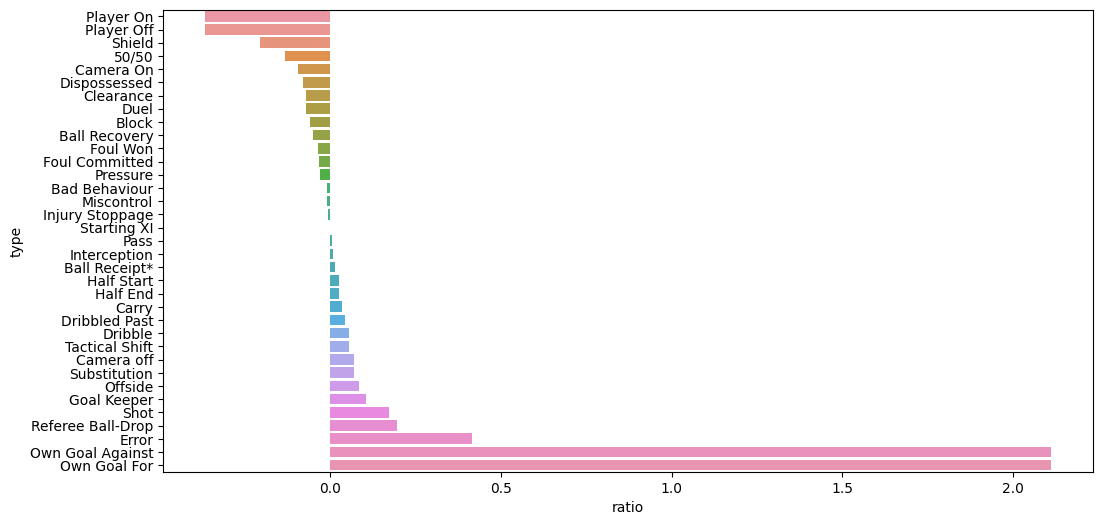

In [52]:
fig,ax = plt.subplots(figsize=(12,6), ncols=1)

sort_val2 = 'ratio'
p2 = sns.barplot(data=event_cnt_df.sort_values(by=sort_val2), y='type' ,x=sort_val2, orient='h', ax=ax)

### Finding 1
The event count analysis depicts what you would anticipate for high scoring games.  There are more own goals for and against, more errors, more shots, more Goal Keeper involvement, more offsides, more carries/dribbles/dribbled past event, and generally more offense.  The own goals probably correlate well with teams which shoot more, since there are more opportunities for such an event to occur.

In [54]:
hsa_tactics=(hsa_events_df
 .query('type=="Starting XI"')
 .dropna(axis=1,how='all')
 .tactics.apply(lambda x: eval(x)['formation'])
 .value_counts()
)

In [61]:
non_hsa_tactics=(non_hsa_events_df
 .query('type=="Starting XI"')
 .dropna(axis=1,how='all')
 .tactics.apply(lambda x: eval(x)['formation'])
 .value_counts()
)

In [62]:
(pd.concat([hsa_tactics.rename('HSA'),non_hsa_tactics.rename('Non_HSA')], axis=1)
 .assign(delta = lambda df: df.HSA-df.Non_HSA)
)

,HSA,Non_HSA,delta
tactics,,,
433,56.0,50.0,6.0
4231,52.0,56.0,-4.0
442,48.0,42.0,6.0
41212,14.0,11.0,3.0
4411,8.0,5.0,3.0
352,8.0,16.0,-8.0
343,8.0,4.0,4.0
3412,6.0,4.0,2.0
4141,6.0,11.0,-5.0


### Analyzing Event Types
After evaluating the events in aggregate, specific event type analsyis can be conducted to determine the specifics of the event group.  The natural place to start in high scoring affairs is shooting. 

In [63]:
# defining universal event extractor function
def event_extract(match_ids, type_id):
    '''Returns all events matching the specified type using the statsbomb library.
    matchid = number or array of numbers containing matchid
    type = event type, for example: 'Pass', 'Ball Receipt*', 'Carry',
       'Shot', 'Goal Keeper', 'Duel', 'Clearance', 'Ball Recovery', 'Block', 'Foul Committed'
    '''
    type_df = pd.DataFrame()
    for i in match_ids:
        type_df = pd.concat([sb.events(i).query("type==@type_id"),type_df])
    return type_df

In [64]:
try:
    hsa_shots_df = pd.read_csv('./data/hsa_shots_df.csv')
    print('read CSV')
except:  # noqa: E722
    hsa_shots_df = (event_extract(hsa_matches,type_id='Shot')
                    .dropna(axis=1, how='all')
                    .assign(x = lambda df: df.location.apply(lambda x: x[0]),
                            y = lambda df: df.location.apply(lambda x: x[1]),
                            time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    hsa_shots_df.to_csv('./data/hsa_shots_df.csv')

read CSV


In [65]:
hsa_shots_fin_df = hsa_shots_df

In [66]:
(hsa_shots_fin_df
 .type
 .value_counts()
)

type
Shot    3190
Name: count, dtype: int64

### Plotting Shots
With all 3000+ shot events in a dataframe, a plot of the shot locations across all the games should provide some be helpful as a first evaluation of the data.  An effort will not be made to correct team directions.  All shots will be plots at the location on which they are recorded, meaning everything will be on one end of the field.  This should not impact visual since it will keep eveything on the same view.  

---

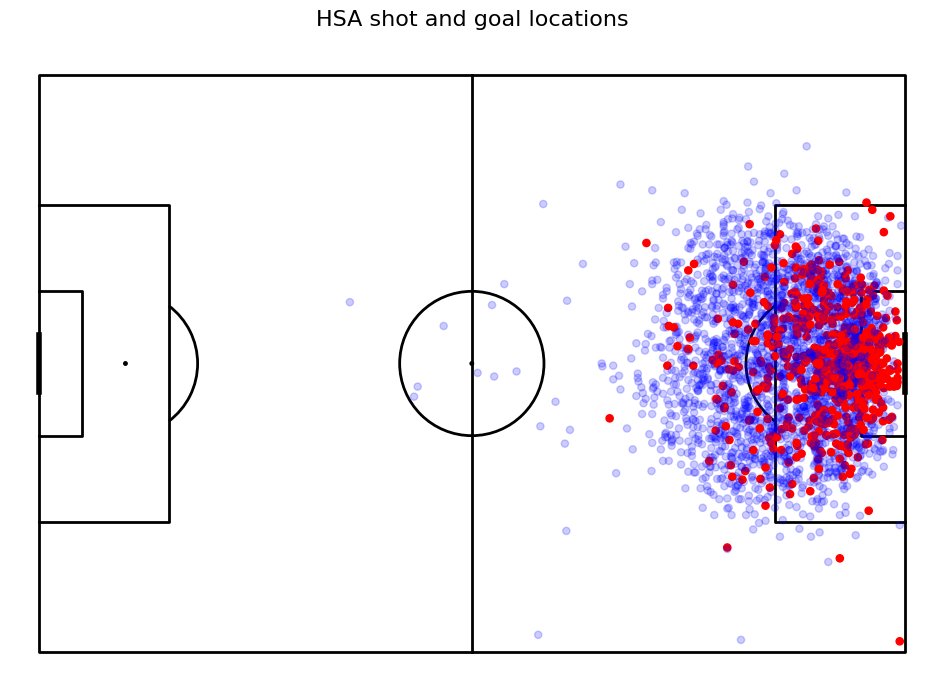

In [67]:
pitch = mpl.Pitch(line_color = "black")
fig, ax = pitch.draw(figsize=(10, 7))
#Size of the pitch in yards (!!!)
pitchLengthX = 120
pitchWidthY = 80
for i,shot in hsa_shots_fin_df.iterrows():
    #get the information
    x=shot.x
    y=shot.y
    goal=shot['shot_outcome']=='Goal'
    #set circlesize
    circleSize=0.5
    #plot goal
    if goal:
        shotCircle=plt.Circle((x,y),circleSize,color="red")
        # plt.text(x+1,y-2,shot['player_name'])
    else:
        shotCircle=plt.Circle((x,y),circleSize,color="blue")
        shotCircle.set_alpha(.2)
    ax.add_patch(shotCircle)
#set title
fig.suptitle("HSA shot and goal locations", fontsize = 16)
fig.set_size_inches(10, 7)
plt.show()

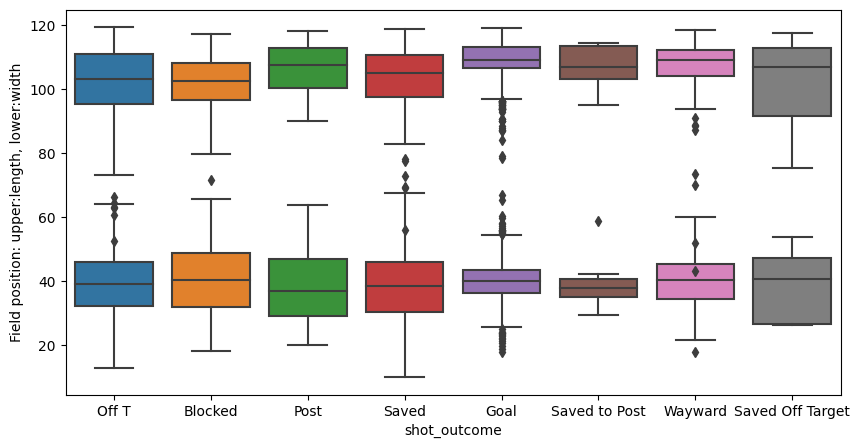

In [68]:
fig,ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=hsa_shots_fin_df,x='shot_outcome',y='x')
sns.boxplot(data=hsa_shots_fin_df,x='shot_outcome',y='y')

ax.set_ylabel('Field position: upper:length, lower:width')

plt.show()

### Findings 2
Nothing to surprising.  Most of the shots come from the magic section of the field in front of the goal and inside or just at the edge of the box.  To evaluate the result in this view all of the other games from the original data set would need to be plotted seperately do determine if there was anything different associated with the shot location information. Perhaps it would be good to determine the total number of shots per game, and other similar concepts game by game.  A sample of 110 games that did not qualify as HSA matches will be extracted to help with the comparison.

In [69]:
len(non_hsa_matches) # too many matches to extract

3206

In [70]:
try:
    shots_df_norm = pd.read_csv('./data/shots_df_norm.csv')
    print('read CSV')
except:  # noqa: E722
    np.random.seed(42)
    shots_df_norm = (event_extract(np.random.choice(non_hsa_matches,size=110),type_id='Shot')
                    .dropna(axis=1, how='all')
                    .assign(x = lambda df: df.location.apply(lambda x: x[0]),
                            y = lambda df: df.location.apply(lambda x: x[1]),
                            time = lambda df: pd.to_timedelta(df.timestamp))
                    )
    print('Used statsbomb API')
    shots_df_norm.to_csv('./data/shots_df_norm.csv')

read CSV


In [71]:
non_hsa_shots_fin_df = shots_df_norm

In [72]:
(hsa_shots_df.type.value_counts())/(non_hsa_shots_fin_df
 .type
 .value_counts()
)

type
Shot    1.172363
Name: count, dtype: float64

### Findings 3
Across 110 games, the HSA group has 469 more shots taken for a 17% total increase in shooting across the game set.  While limited effort was taken other than evaluating score lines, it would seem that even with lop sided results in the base group (non high scoring affairs), they still shoot less often than the HSA games.  This should mean that the points per game will also hold. 

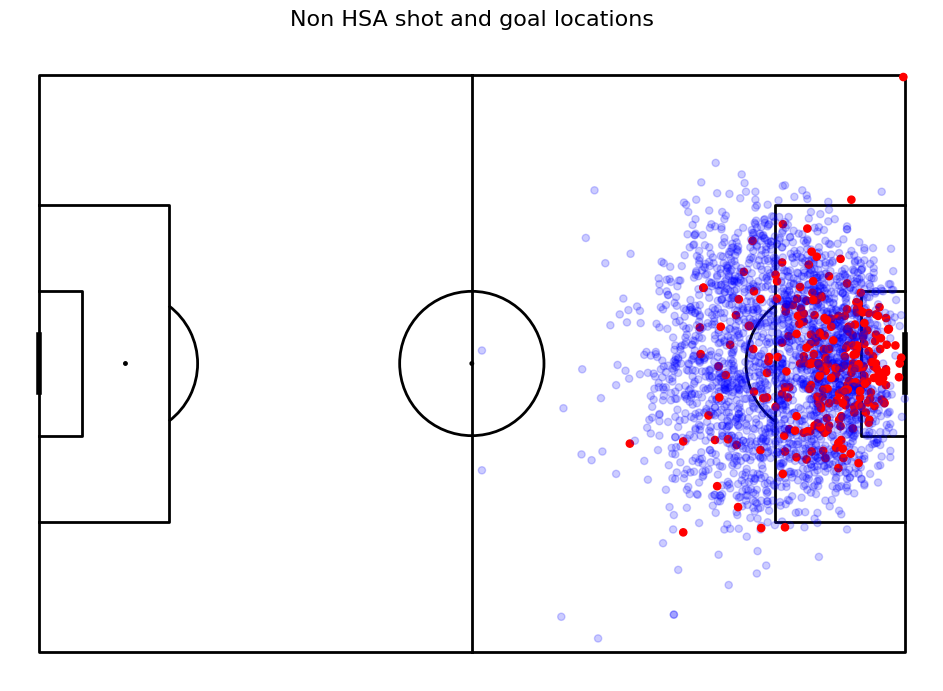

In [73]:
pitch = mpl.Pitch(line_color = "black")
fig, ax = pitch.draw(figsize=(10, 7))
#Size of the pitch in yards (!!!)
pitchLengthX = 120
pitchWidthY = 80
for i,shot in non_hsa_shots_fin_df.iterrows():
    #get the information
    x=shot.x
    y=shot.y
    goal=shot['shot_outcome']=='Goal'
    #set circlesize
    circleSize=0.5
    #plot goal
    if goal:
        shotCircle=plt.Circle((x,y),circleSize,color="red")
        # plt.text(x+1,y-2,shot['player_name'])
    else:
        shotCircle=plt.Circle((x,y),circleSize,color="blue")
        shotCircle.set_alpha(.2)
    ax.add_patch(shotCircle)
#set title
fig.suptitle("Non HSA shot and goal locations", fontsize = 16)
fig.set_size_inches(10, 7)
plt.show()

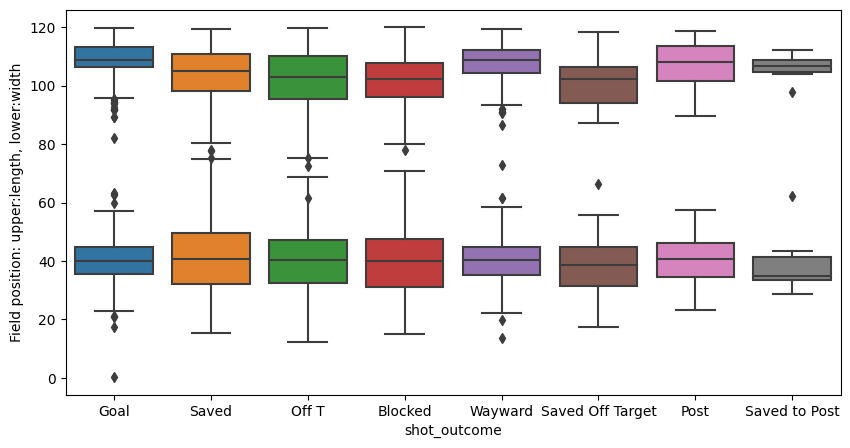

In [74]:
fig,ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=non_hsa_shots_fin_df,x='shot_outcome',y='x')
sns.boxplot(data=non_hsa_shots_fin_df,x='shot_outcome',y='y')

ax.set_ylabel('Field position: upper:length, lower:width')

plt.show()

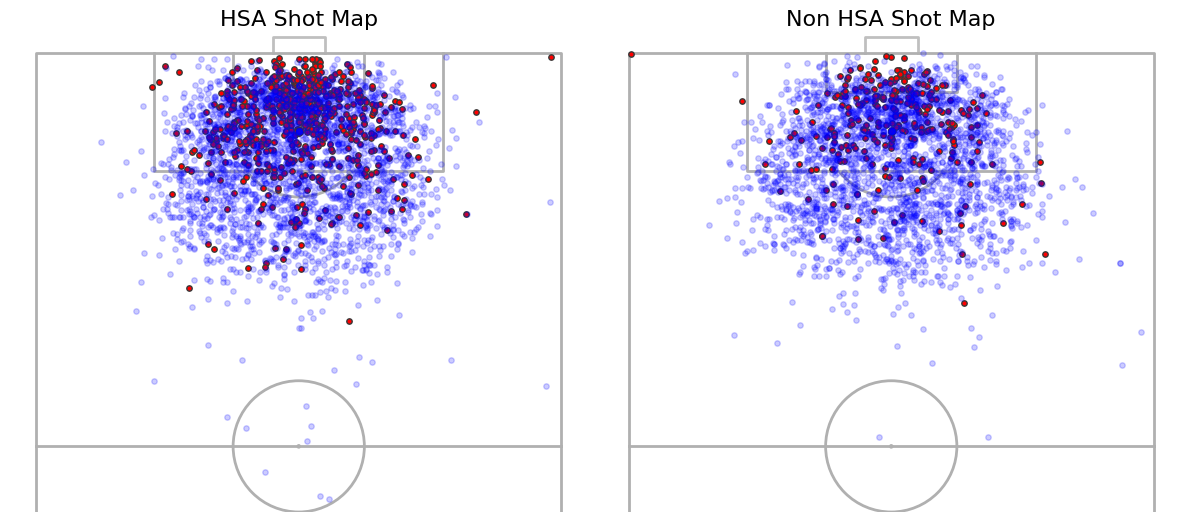

In [75]:
pitch = mpl.VerticalPitch(pad_bottom=10,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8)  # control the goal transparency
fig, ax = pitch.draw(figsize=(12, 10), nrows=1, ncols=2)
# HSA pitch view
data1 = hsa_shots_fin_df.query("shot_outcome=='Goal'")
sc1 = pitch.scatter(data1.x, data1.y, s=15,c='red', edgecolors='#383838', ax=ax[0])
data2 = hsa_shots_fin_df.query("shot_outcome!='Goal'")
sc12= pitch.scatter(data2.x, data2.y, s=15,c='blue',alpha=0.2, ax=ax[0])
# title text
txt = ax[0].text(x=40, y=125, s='HSA Shot Map',size=16, va='center', ha='center')
# Non HSA Pitch view
data3 = non_hsa_shots_fin_df.query("shot_outcome=='Goal'")
sc3 = pitch.scatter(data3.x, data3.y, s=15,c='red', edgecolors='#383838', ax=ax[1])
data4 = non_hsa_shots_fin_df.query("shot_outcome!='Goal'")
sc14= pitch.scatter(data4.x, data4.y, s=15,c='blue',alpha=0.2, ax=ax[1])
# title text
txt = ax[1].text(x=40, y=125, s='Non HSA Shot Map',size=16, va='center', ha='center')


In [76]:
(hsa_shots_fin_df
 .assign(shots = 1,
         xg_avg = lambda df: df.shot_statsbomb_xg)
 .loc[:,['match_id','shots','x','y','shot_statsbomb_xg','xg_avg']]
 .groupby("match_id").agg({'shots':'sum','x':'mean','y':'mean','shot_statsbomb_xg':'sum', 'xg_avg':'mean'})
).mean(axis=0)

shots                 29.000000
x                    104.466198
y                     39.448458
shot_statsbomb_xg      4.024040
xg_avg                 0.138730
dtype: float64

In [77]:
(non_hsa_shots_fin_df
 .assign(shots = 1,
         xg_avg = lambda df: df.shot_statsbomb_xg)
 .loc[:,['match_id','shots','x','y','shot_statsbomb_xg','xg_avg']]
 .groupby("match_id").agg({'shots':'sum','x':'mean','y':'mean','shot_statsbomb_xg':'sum', 'xg_avg':'mean'})
).mean(axis=0)

shots                 24.963303
x                    103.650390
y                     40.117515
shot_statsbomb_xg      2.577034
xg_avg                 0.103338
dtype: float64

### Finding 2
On average, the HSA games produce more shots, the position is slighly closer to goal, and the expected goals value is higher than the games falling into a more traditional score line.  This would indicate that there is something different happening in these games, and the result is not simply luck associated with chance.  This is not a formal hypothesis with a null value.  After further analysis, an effort will be made to incorporate a null value hypothesis check against the stated case that HSA games produce a different on field product, and result in "Open" games and subsequently achieve more goals.

### Shooters
Having established that HSAs generally produce more shots from better locations, the next logical question is why?  There are many questions about what creates and open game.  Is the driver formation based, is it strictly talent dependenet?  Niether of these seems likely across the numerous teams involved.  Below, and characterization of the HSA game sets will be provided to give some context to the types of games and players involved.

<Axes: title={'center': 'Average Shots per HSA match by team'}, xlabel='team'>

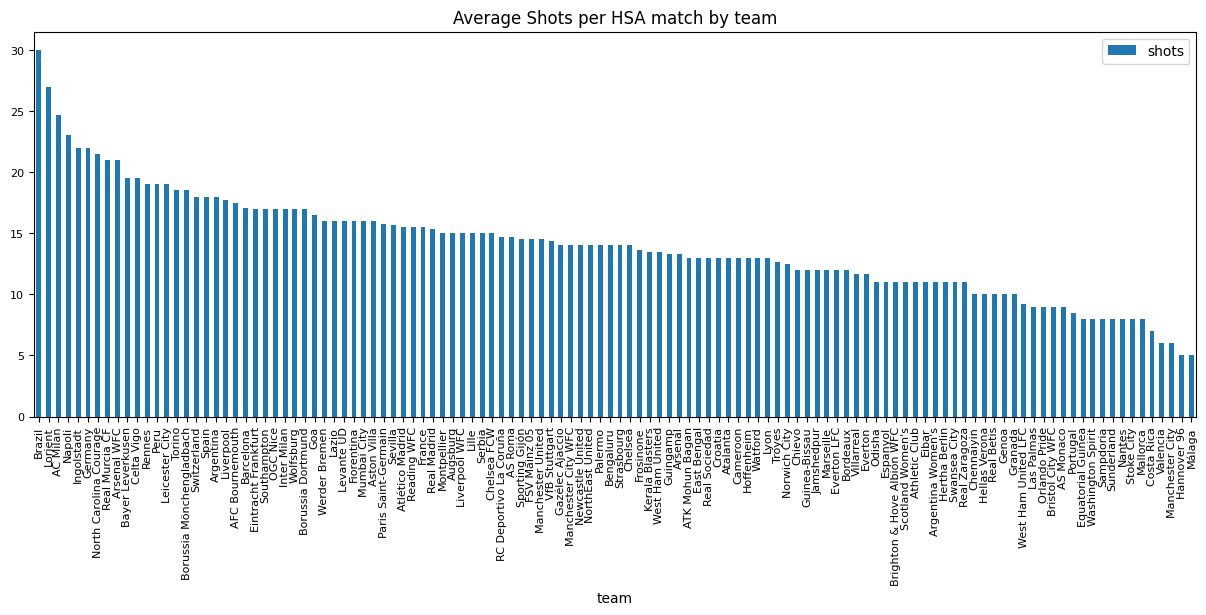

In [78]:
(hsa_shots_fin_df
 .assign(shots = 1)
 .groupby(by=['team','match_id'], as_index=False).shots.sum(numeric_only=True)
 .drop('match_id', axis=1)
 .groupby('team', as_index=False).mean().round(2)
 .sort_values('shots', ascending=False)
 .set_index('team')
).plot.bar(figsize=(15,5), fontsize=8, title='Average Shots per HSA match by team')

<Axes: title={'center': 'HSA Frequency of shot count'}, ylabel='Frequency'>

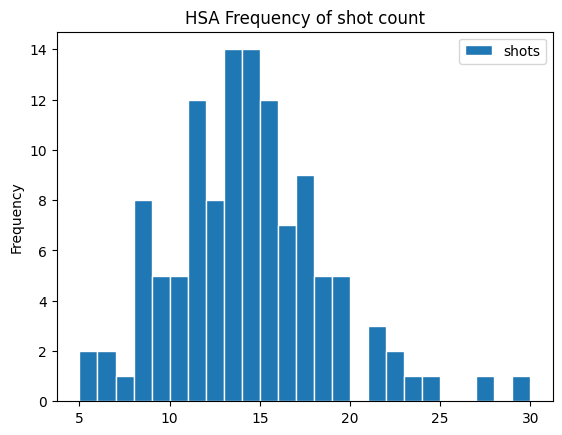

In [79]:
(hsa_shots_fin_df
 .assign(shots = 1)
 .groupby(by=['team','match_id'], as_index=False).shots.sum(numeric_only=True)
 .drop('match_id', axis=1)
 .groupby('team', as_index=False).mean().round(2)
#  .sort_values('shots', ascending=False)
 .set_index('team')
).plot.hist(bins=25,edgecolor='white', title= "HSA Frequency of shot count")

<Axes: title={'center': 'Non HSA Frequency of shot count'}, ylabel='Frequency'>

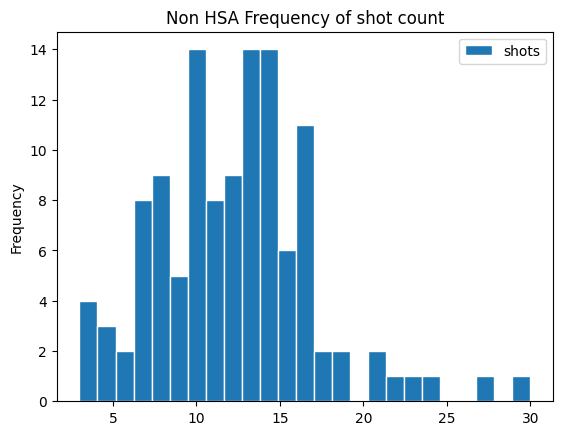

In [80]:
(non_hsa_shots_fin_df
 .assign(shots = 1)
 .groupby(by=['team','match_id'], as_index=False).shots.sum(numeric_only=True)
 .drop('match_id', axis=1)
 .groupby('team', as_index=False).mean().round(2)
#  .sort_values('shots', ascending=False)
 .set_index('team')
).plot.hist(bins=25,edgecolor='white', title= "Non HSA Frequency of shot count")

### Finding 3
Clearly, there is a wide variety of teams and resultant number of shots.  Remember, the classification of a high scoring affair for the purposes of this analysis is more than 5 total between both teams, and less that three goals between the teams.  A 4-2 scoreline would be possibles in the hsa group.  It looks as though the midpoint is the most frequent shot total.  Interestingly, there is not a distinct difference in the total number of shots per game between the HSA and Non HSA game.  

---

The number of shots taken per game is similar, at least from a frequency distribution across 110 games, but the position of the shots seems to be closer to goal.  A secondary analysis should be made to validate that the games in question are the result of more open play goals than set piece of penalty kick goals.  As part of the current varient, an effort will be made to evaluate the team shape displayed based on average event position.    

### Passing Heatmaps
After establishing that HSA matches result in more shots from slightly closer to the goal, the natural follow up question is why?  The first option to start with to answer this question is passing heatmaps, and the associated calculated aggregates.  This analysis will be conducted following the methodology provided in mpl soccer documentation.  Again, the intent is to determine if there is a difference between HSA and non HSA matches.  The analysis will maintain the same sample non HSA group of 110 games as a direct comparison to the HSA grouping extracted at the beginning. 

For passing heatmaps only accurate/successful passes are leveraged. Information is needed about pass start and end location as well as pass distance to determine the how the network of vectors is shaped.

In [81]:
try:
    hsa_passing_df = pd.read_csv('./data/hsa_passing_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    hsa_passing_df = event_extract(hsa_matches,type_id='Pass')
    print('Used Statsbomb API')
    hsa_passing_df.to_csv('./data/hsa_passing_df.csv')

Read CSV from memory


In [82]:
try:
    non_hsa_passing_df = pd.read_csv('./data/non_hsa_passing_df.csv')
    print('Read CSV from memory')
except:  # noqa: E722
    np.random.seed(42)
    non_hsa_passing_df = event_extract(np.random.choice(non_hsa_matches,size=110),type_id='Pass')
    print('Used Statsbomb API')
    non_hsa_passing_df.to_csv('./data/non_hsa_passing_df.csv')

Read CSV from memory


In [83]:
hsa_passing_df_fin = (hsa_passing_df
                      .dropna(how='all', axis=1)
                      .query("pass_outcome.isnull()")
                      .assign(x = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[0]),
                              y = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda y: y[1]),
                              end_x = lambda df: df.pass_end_location.apply(lambda x: x[1:-1].split(',')).apply(lambda x:x[0]),
                              end_y = lambda df: df.pass_end_location.apply(lambda x: x[1:-1].split(',')).apply(lambda y:y[1]))
                      .astype({'x':'float','y':'float','end_x':'float','end_y':'float'})
                      .query('pass_type.isnull()')

)

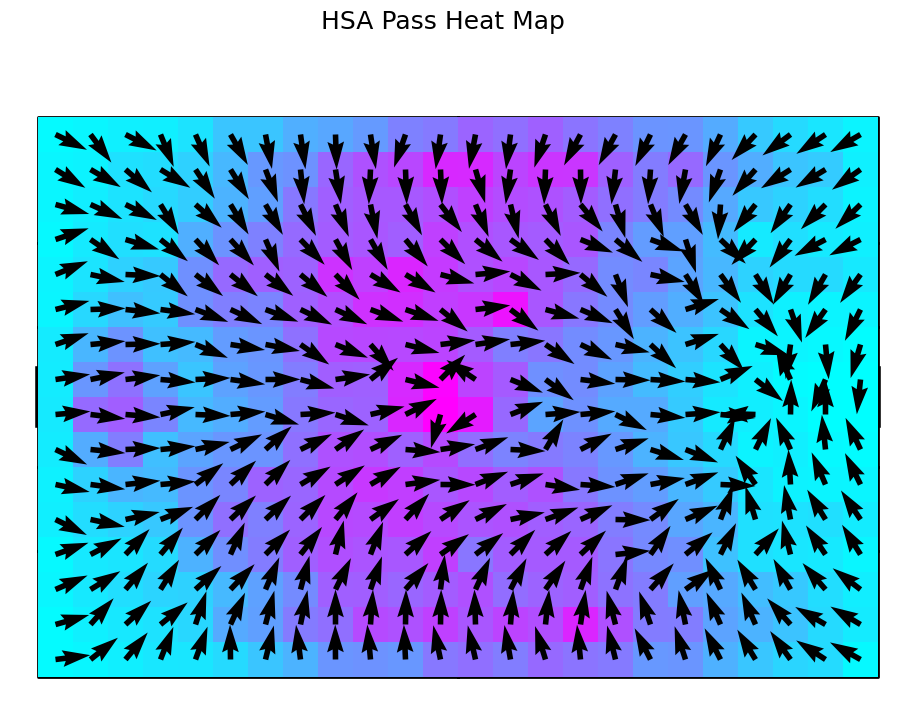

In [84]:
data=hsa_passing_df_fin
# pitch
pitch = mpl.Pitch(line_color='black')
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True, tight_layout=False)
# heatmap
bins = (24, 16)
bs_heatmap = pitch.bin_statistic(data.x, data.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='cool')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(data.x, data.y, data.end_x, data.end_y, color='black', arrow_type='same', bins=bins, ax=ax)
fig.suptitle("HSA Pass Heat Map", fontsize = 18)
plt.show()

In [85]:
non_hsa_passing_df_fin = (non_hsa_passing_df
                      .dropna(how='all', axis=1)
                      .query("pass_outcome.isnull()")
                      .assign(x = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[0]),
                              y = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda y: y[1]),
                              end_x = lambda df: df.pass_end_location.apply(lambda x: x[1:-1].split(',')).apply(lambda x:x[0]),
                              end_y = lambda df: df.pass_end_location.apply(lambda x: x[1:-1].split(',')).apply(lambda y:y[1]))
                      .astype({'x':'float','y':'float','end_x':'float','end_y':'float'})
                      .query('pass_type.isnull()')

)

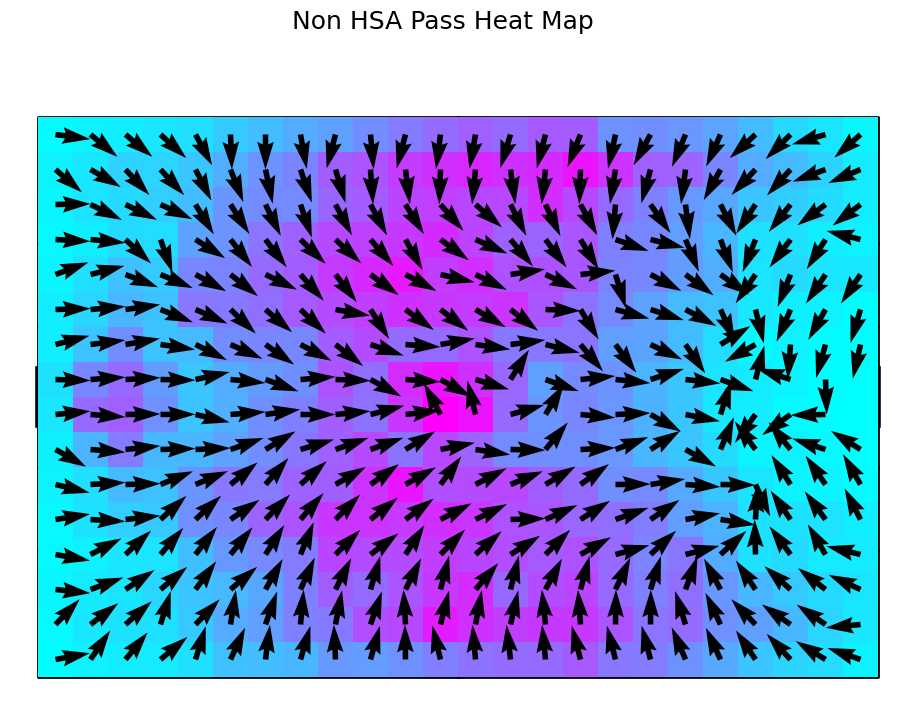

In [86]:
data=non_hsa_passing_df_fin
# pitch
pitch = mpl.Pitch(line_color='black')
fig, ax = pitch.draw(figsize=(12, 8), constrained_layout=True, tight_layout=False)
# heatmap
bins = (24, 16)
bs_heatmap = pitch.bin_statistic(data.x, data.y, statistic='count', bins=bins)
hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='cool')
# plot the pass flow map with a single color ('black') and length of the arrow (5)
fm = pitch.flow(data.x, data.y, data.end_x, data.end_y, color='black', arrow_type='same', bins=bins, ax=ax)
fig.suptitle("Non HSA Pass Heat Map", fontsize = 18)
plt.show()

In [87]:
(hsa_passing_df_fin
 .loc[:,['match_id','x','y','end_x','end_y','pass_length']]
 .groupby('match_id', as_index=False).mean()
 .drop('match_id', axis=1)
).mean()

x              57.877318
y              39.901614
end_x          61.637445
end_y          39.917562
pass_length    19.532454
dtype: float64

In [88]:
(non_hsa_passing_df_fin
 .loc[:,['match_id','x','y','end_x','end_y','pass_length']]
 .groupby('match_id', as_index=False).mean()
 .drop('match_id', axis=1)
).mean()

x              58.405423
y              39.803950
end_x          62.159404
end_y          39.918835
pass_length    19.591198
dtype: float64

In [89]:
import cmasher as cmr

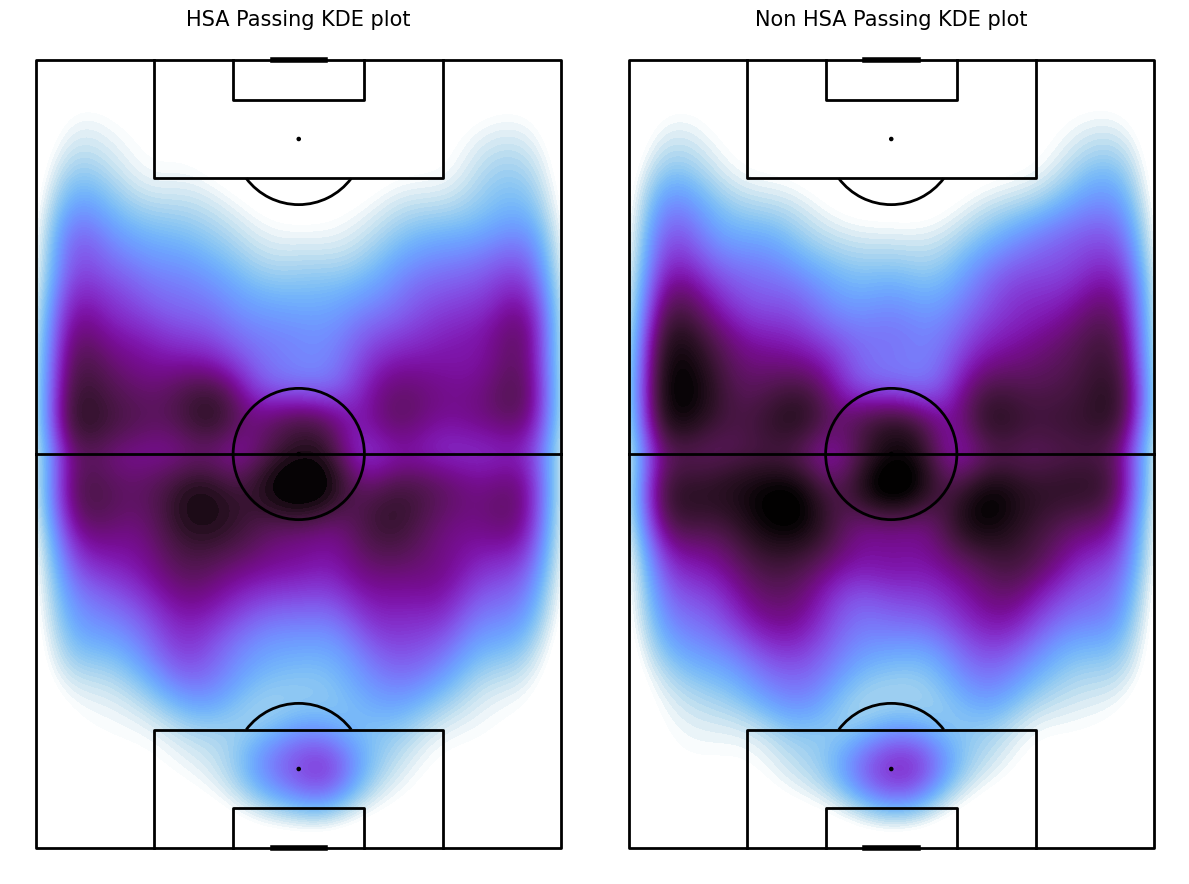

In [73]:
# pitch = mpl.VerticalPitch(line_color='black', line_zorder=2)
# fig, ax = pitch.draw(figsize=(12,10), ncols=2)
# data1=hsa_passing_df_fin
# kdeplot_light = pitch.kdeplot(data1.x, data1.y, ax=ax[0], cmap=cmr.voltage_r, fill=True, levels=100)
# ax_title = ax[0].set_title('HSA Passing KDE plot', fontsize=15)
# data1=non_hsa_passing_df_fin
# kdeplot_light = pitch.kdeplot(data1.x, data1.y, ax=ax[1], cmap=cmr.voltage_r, fill=True, levels=100)
# ax_title = ax[1].set_title('Non HSA Passing KDE plot', fontsize=15)

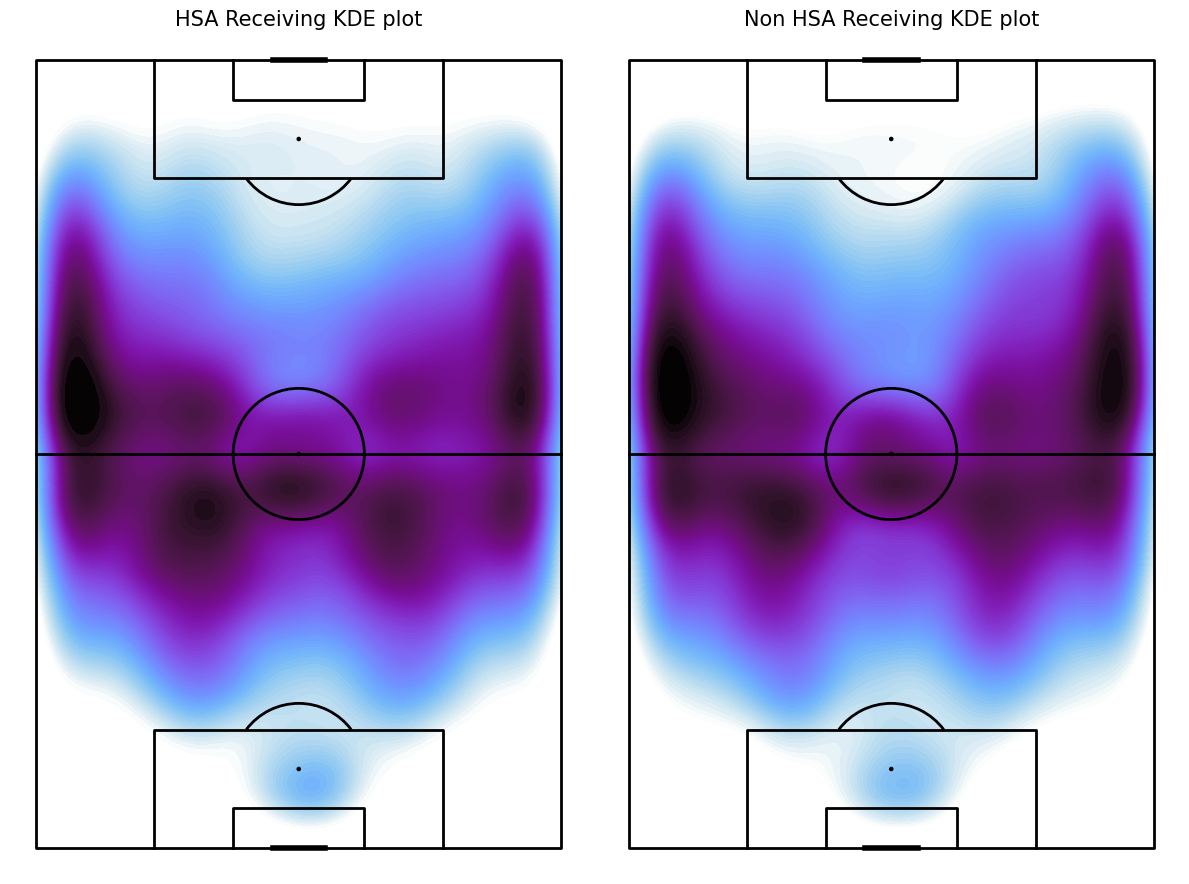

In [74]:
# pitch = mpl.VerticalPitch(line_color='black', line_zorder=2)
# fig, ax = pitch.draw(figsize=(12,10), ncols=2)
# data1=hsa_passing_df_fin
# kdeplot_light = pitch.kdeplot(data1.end_x, data1.end_y, ax=ax[0], cmap=cmr.voltage_r, fill=True, levels=100)
# ax_title = ax[0].set_title('HSA Receiving KDE plot', fontsize=15)
# data1=non_hsa_passing_df_fin
# kdeplot_light = pitch.kdeplot(data1.end_x, data1.end_y, ax=ax[1], cmap=cmr.voltage_r, fill=True, levels=100)
# ax_title = ax[1].set_title('Non HSA Receiving KDE plot', fontsize=15)

### Findings
The first forray into passing shows almost no difference between the HSA and Non HSA groups.  It is actually so close initially it was thought to be an error.  After a recheck, the plots and calculations were verified to be accurate.  More digging will be needed.  The pattern may be game specific, which will make things more difficult since individual competition match ups will be the driver for the higher scoring outcome.  

---

### Changing possession
Perhaps the high scoring games involve a high number of posessions created through a press higher up the pitch, which allows the scoring team to immediately convert the advanced positions into shots.  To determine if this is the case, the event type for gaining possession along with its location will need to be determined.  A quick plot of the results should indicate the accuracy of the assumption.

In [103]:
(hsa_events_df
 .query('type.isin(["Dispossessed", "Interception", "Miscontrol", "Clearance"])')
 .dropna(axis=1, how='all')
 .assign(x = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda x: x[0]),
         y = lambda df: df.location.apply(lambda x: x[1:-1].split(',')).apply(lambda y: y[1]))
).iloc[0]

Unnamed: 0                                               2686
clearance_aerial_won                                      NaN
clearance_body_part                                       NaN
clearance_head                                            NaN
clearance_left_foot                                       NaN
clearance_right_foot                                      NaN
counterpress                                              NaN
duration                                                  0.0
id                       60492103-4ef6-476c-90ab-9ba0c4e823eb
index                                                      38
interception_outcome                                      NaN
location                                         [73.6, 74.7]
match_id                                                68338
minute                                                      0
miscontrol_aerial_won                                     NaN
off_camera                                                NaN
out     